In [1]:
from math import sqrt
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageFilter
import numpy as np
from collections import defaultdict
from skimage import io as io
from skimage import exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import daisy
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.feature import hog
from skimage.feature import corner_harris, corner_subpix, corner_peaks
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from time import time
from sklearn.externals import joblib

In [2]:
with open("data/annotations/instances_train2014.json") as read_file:
    train = json.load(read_file)
#with open("data/annotations_trainval2014/annotations/instances_val2014.json") as read_file:
#    val = json.load(read_file)

Number of images in 2014 train: 82783
Number of annotations in 2014 train: 604907
Number of annotations/image in 2014 train: 7.307140354903785
82081
82081
Label density in 2014 train: 0.0913392544362973
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])


0person: 185316
1bicycle: 4955
2car: 30785
3motorcycle: 6021
4airplane: 3833
5bus: 4327
6train: 3159
7truck: 7050
8boat: 7590
9traffic light: 9159
10fire hydrant: 1316
11stop sign: 1372
12parking meter: 833
13bench: 6751
14bird: 7290
15cat: 3301
16dog: 3774
17horse: 4666
18sheep: 6654
19cow: 5686
20elephant: 3905
21bear: 903
22zebra: 3685
23giraffe: 3596
24backpack: 6200
25umbrella: 7865
26handbag: 8778
27tie: 4497
28suitcase: 4251
29frisbee: 1862
30skis: 4698
31snowboard: 1960
32sports ball: 4392
33kite: 6560
34baseball bat: 2400
35baseball glove: 2689
36skateboard: 4012
37surfboard: 4161
38tennis racket: 3411
39bottle: 16983
40wine glass: 5618
41cup: 14513
42fork: 3918
43knife: 5536
44spoon: 4287
45bowl: 10064
46

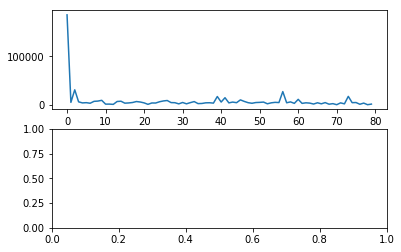


10 least used features 

[('hair drier', 135), ('toaster', 156), ('parking meter', 833), ('bear', 903), ('scissors', 1073), ('microwave', 1189), ('fire hydrant', 1316), ('stop sign', 1372), ('toothbrush', 1377)]



10 most used features 

[('handbag', 8778), ('traffic light', 9159), ('bowl', 10064), ('dining table', 11167), ('cup', 14513), ('bottle', 16983), ('book', 17315), ('chair', 27147), ('car', 30785), ('person', 185316)]




In [3]:
categories = train["categories"]
#print(categories)
train_images = train["images"]
#val_images = val["images"]
print("Number of images in 2014 train: "+str(len(train_images)))
#print("Number of images in 2014 val: "+str(len(val_images)) +"\n")
train_annotations = train["annotations"]
#print(train_annotations[1:20])
#val_annotations = val["annotations"]
print("Number of annotations in 2014 train: "+str(len(train_annotations)))
#print("Number of annotations in 2014 val: "+str(len(val_annotations)) + "\n")
print("Number of annotations/image in 2014 train: "+str(len(train_annotations)/len(train_images)))
#print("Number of annotations/image in 2014 val: " + str(len(val_annotations)/len(val_images)) + "\n")
train_categories = np.zeros(100, dtype=object)
#val_categories = np.zeros(100, dtype=object)
#itemsets = [[] for i in range(581922)]
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
print(len(itemsets))
unique_itemsets = []
for entry in itemsets:
    if(entry not in unique_itemsets):
        unique_itemsets.append(entry)
print(len(unique_itemsets))
#for annotation in val_annotations:
#    val_categories[annotation['category_id']] += 1
train_categories = train_categories[train_categories != 0]
#val_categories = val_categories[val_categories != 0]
print("Label density in 2014 train: "+str(len(train_annotations)/len(train_categories)/len(train_images)))
#print("Label density in 2014 val: "+str(len(val_annotations)/len(val_categories)/len(val_images)))
print(train.keys())
print("\n")
#print(images[1:10])
#print("\n")
#print(annotations[1:10])
#print("\n")
#print(categories)
for i in range(0, len(train_categories)):
    print(str(i) + categories[i]["name"] + ": " + str(train_categories[i]))
    train_categories[i] = (categories[i]["name"], train_categories[i])
#for i in range(0, len(val_categories)):
    #print(categories[i]["name"] + ": " + str(train_categories[i]))
#    val_categories[i] = (categories[i]["name"], val_categories[i])
plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in train_categories])
plt.subplot(212)
#plt.plot([i[1] for i in val_categories])
plt.show()
train_categories = sorted(train_categories, key=lambda tup: tup[1], reverse=False)
#val_categories = sorted(val_categories, key=lambda tup: tup[1], reverse=False)
print("\n10 least used features \n")
print(train_categories[0:9])
print("\n")
#print(val_categories[0:9])
print("\n10 most used features \n")
print(train_categories[-10:])
print("\n")
#print(val_categories[-10:])

In [4]:
image_id = 9 #9,25,30,34,36,49
def findAnnotations(id, property):
    items = []
    for annotation in train_annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items
items = findAnnotations(image_id, 'image_id')

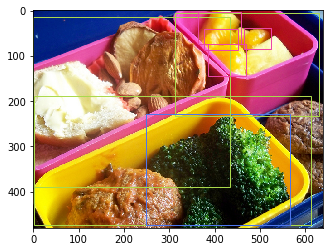

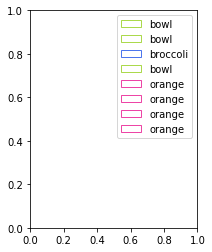

In [5]:
def findValueDictionary(dict,key,value, returnkey):
    for entry in dict:
        if entry[key] == value:
            return entry[returnkey]

image_id_string = str(image_id).zfill(12)
image = np.array(Image.open('data/train2014/COCO_train2014_'+ image_id_string +'.jpg'), dtype=np.uint8)
fig,ax = plt.subplots(1)
ax.imshow(image)
colors = np.random.random((len(categories)+10, 3))
i=0
bbox_list = []
item_list = []
for item in items:
    label = findValueDictionary(categories, 'id', item['category_id'], 'name')
    rect = patches.Rectangle((item['bbox'][0], (item['bbox'][1])), item['bbox'][2], item['bbox'][3],linewidth=1,edgecolor=colors[item['category_id']-1],facecolor='none', label= label)
    ax.add_patch(rect)
    bbox_list.append(rect)
    item_list.append(item['category_id'])
#print(items)
plt.figure(figsize=(3,4))
plt.legend(handles=bbox_list)
plt.show()

In [6]:
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]


def getBoundingBoxesPicture(annotations, categories, path):
    bounded_images = []
    bounded_annotations = []
    bounded = [[],[]]
    for annotation in annotations:
        image_id = annotation['image_id']
        image_id_string = str(image_id).zfill(12)
        image = np.array(Image.open(path + image_id_string +'.jpg').convert("L").filter(ImageFilter.GaussianBlur(radius = 2)), dtype=np.uint8)
        image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                               , ( 80, 80),
                       anti_aliasing=True)
        bounded_images.append(image_resized)
        bounded_annotations.append(annotation['category_id'])
    bounded = [len(bounded_images),2]
    bounded[0] = bounded_images
    bounded[1] = bounded_annotations
    return bounded

path = "data/train2014/COCO_train2014_"
category = "category_id"
category_imgs21 = getBoundingBoxesPicture(findAnnotations(21, category), categories, path)
#print(category_imgs21[0])
category_imgs70 = getBoundingBoxesPicture(findAnnotations(70, category), categories, path)
#print(category_imgs70[0])
category_imgs78 = getBoundingBoxesPicture(findAnnotations(78, category), categories, path)

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


NameError: name 'category_imgs5' is not defined

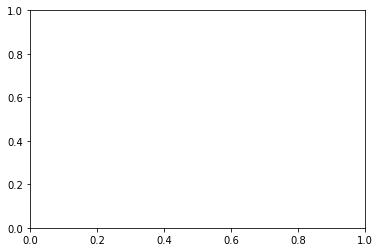

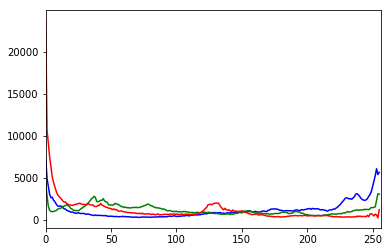

In [8]:
gray_img = rgb2gray(image)
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


In [9]:
def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    descs = daisy(gray_image, step=180, radius=2, rings=3, histograms=6,
                         orientations=8, visualize=False)
    return descs

def calculateFeatures(imgs):
    hog_features = []
    daisy_features = []
    for img in imgs[0]:
        gray_img = rgb2gray(img)
        hog_features.append(calculateHogFeatures(gray_img,8,16,1))
        #daisy_features.append(calculateDaisyFeatures(gray_img))
    return hog_features#, daisy_features

features21 = calculateFeatures(category_imgs21)
features70 = calculateFeatures(category_imgs70)
features78 = calculateFeatures(category_imgs78)
'''
descs, descs_img = daisy(gray_img, step=180, radius=58, rings=3, histograms=6,
                         orientations=8, visualize=True)

print(descs)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()
'''

"\ndescs, descs_img = daisy(gray_img, step=180, radius=58, rings=3, histograms=6,\n                         orientations=8, visualize=True)\n\nprint(descs)\nfig, ax = plt.subplots()\nax.axis('off')\nax.imshow(descs_img)\ndescs_num = descs.shape[0] * descs.shape[1]\nax.set_title('%i DAISY descriptors extracted:' % descs_num)\nplt.show()\n"

In [12]:
features = features21 + features70 + features78
labels = category_imgs21[1] + category_imgs70[1] + category_imgs78[1]
x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.25, random_state=42)
#print(features[0])
print(len(features))
print(len(labels))

9748
9748


In [16]:
def svm_fit(x_train, y_train):
    print("Fitting the classifier to train")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Completed in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def svm_save(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
def svm_predict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time() - t0))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
svm = svm_fit(x_train, y_train)
svm_save(svm, 'SVM_test.sav')
svm_predict(x_test, y_test, svm)

Saving file...
File saved
Predicting the test set
Completed in 1.579s
              precision    recall  f1-score   support

          21       0.89      0.94      0.92      1438
          70       0.86      0.81      0.83       717
          78       0.83      0.73      0.78       282

   micro avg       0.88      0.88      0.88      2437
   macro avg       0.86      0.82      0.84      2437
weighted avg       0.88      0.88      0.88      2437

[[1354   67   17]
 [ 114  578   25]
 [  51   26  205]]


In [ ]:
print(features[0][0])
print(features[1])

fig, ax = plt.subplots(1, figsize=(8, 4))

hog_image_rescaled = exposure.rescale_intensity(features[0][0][1], in_range=(0, 10))

ax.axis('off')
ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
blobs_log = blob_log(gray_img, max_sigma=30, num_sigma=10, threshold=.1)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(gray_img, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(gray_img, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()


In [ ]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, ax = plt.subplots(1, figsize=(8, 4))

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax.axis('off')
ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
print(gray_img)
coords = corner_peaks(corner_harris(gray_img), min_distance=5)

fig, (ax) = plt.subplots(1, figsize=(8, 4))

ax.axis('off')
ax.imshow(image)
ax.plot(coords[:, 1], coords[:, 0], 'or', ms=4)